# CS634 Final Project – Wine Quality Prediction (RF / KNN / Conv1D)

In this notebook we predict wine quality using three models:
Random Forest, K Nearest Neighbors (KNN), and a Conv1D neural network.
We use 10 Fold cross Validation and report per‑fold metrics and overall averages.

## 1. Imports and helper functions

In [1]:
import numpy as ny
import pandas as ps
import math
import matplotlib.pyplot as pt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    brier_score_loss,
    roc_curve,
    auc,
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

RANDOM_STATE = 42
ny.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

#Metrics Helper methodd
def calc_metrics_from_cm(cm):
    TN, FP, FN, TP = cm.ravel()

    def safe_division(a, b):
        return a / b if b != 0 else 0.0

    P = TP + FN
    N = TN + FP

    TPRate = safe_division(TP, P)
    TNRate = safe_division(TN, N)  
    FPRate = safe_division(FP, N)
    FNRate = safe_division(FN, P)
    Precision = safe_division(TP, TP + FP)
    F1 = safe_division(2 * TP, 2 * TP + FP + FN)
    Accuracy = safe_division(TP + TN, P + N)
    Error_rate = 1.0 - Accuracy
    BACC = 0.5 * (TPRate + TNRate)
    TSS = TPRate - FPRate
    denom = (TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)
    HSS = safe_division(2 * (TP * TN - FP * FN), denom)

    return {
        "TP": TP, "TN": TN, "FP": FP, "FN": FN,
        "P": P, "N": N,
        "TPR": TPRate, "TNR": TNRate, "FPR": FPRate, "FNR": FNRate,
        "Precision": Precision, "F1": F1,
        "Accuracy": Accuracy, "Error_rate": Error_rate,
        "BACC": BACC, "TSS": TSS, "HSS": HSS,
    }

#Conv1d Helper method
def build_conv1d(n_features):
    model = Sequential([
        Conv1D(64, 3, activation="relu", input_shape=(n_features, 1)),
        Dropout(0.2),
        Conv1D(32, 3, activation="relu"),
        GlobalMaxPooling1D(),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


## 2. Load the wine_quality dataset

In [2]:
# Dataset path
path = "wine_quality.csv"
wine_data = ps.read_csv(path)

print("Raw dataset shape:", wine_data.shape)
print(wine_data.head(3))

#Target value unique count
if "type" in wine_data.columns:
    print("\nType counts:")
    print(wine_data["type"].value_counts())

df = wine_data.copy()


Raw dataset shape: (6497, 13)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   

   alcohol  quality type  
0      9.4        5  red  
1      9.8        5  red  
2      9.8        5  red  

Type counts:
type
white    4898
red      1599
Name: count, dtype: int64


### Observation:
We can Clearly see that there is imbalance in target variable wine type white colour is more than twice the size of red colour.
To resolve this we will use stratified data sampling and apply stratified k fold cross validation.

## 3. Prepare features (X) and label (y)

In [3]:
# target is the last column: wine type (red/white)
target_col = df.columns[-1]

# Label-encode the target column inside df so it becomes numeric
if df[target_col].dtype == "object":
    label_encoder = LabelEncoder()
    df[target_col] = label_encoder.fit_transform(df[target_col])

x = df.iloc[:, :-1]  # All Columns except target(last one) variable 
y = df.iloc[:, -1]   # Only the target variable

# Label Encoding convert the target variable(which has white,red strings to numbers)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Standerd Scaling
scaler = StandardScaler()
x_scaled = ps.DataFrame(scaler.fit_transform(x), columns=x.columns)

# Convert to numpy arrays
X = x_scaled.values.astype("float32")
y_arr = y_encoded.astype("int32")

print("Features shape:", X.shape)
print("Labels shape:", y_arr.shape)
print("Positives:", int(y_arr.sum()), "Negatives:", int(len(y_arr) - y_arr.sum()))


Features shape: (6497, 12)
Labels shape: (6497,)
Positives: 4898 Negatives: 1599


### Data Visualization


Target column used for classification: type

Value counts for wine type (encoded):
type
1    4898
0    1599
Name: count, dtype: int64


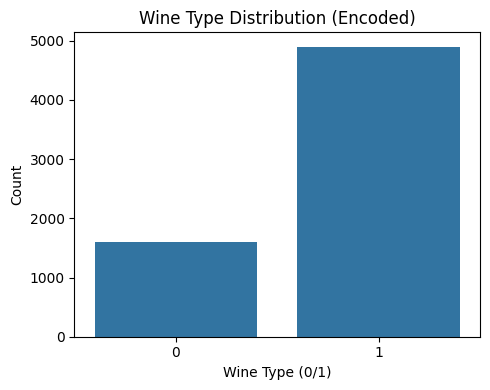


Numeric feature columns:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


<Figure size 1200x800 with 0 Axes>

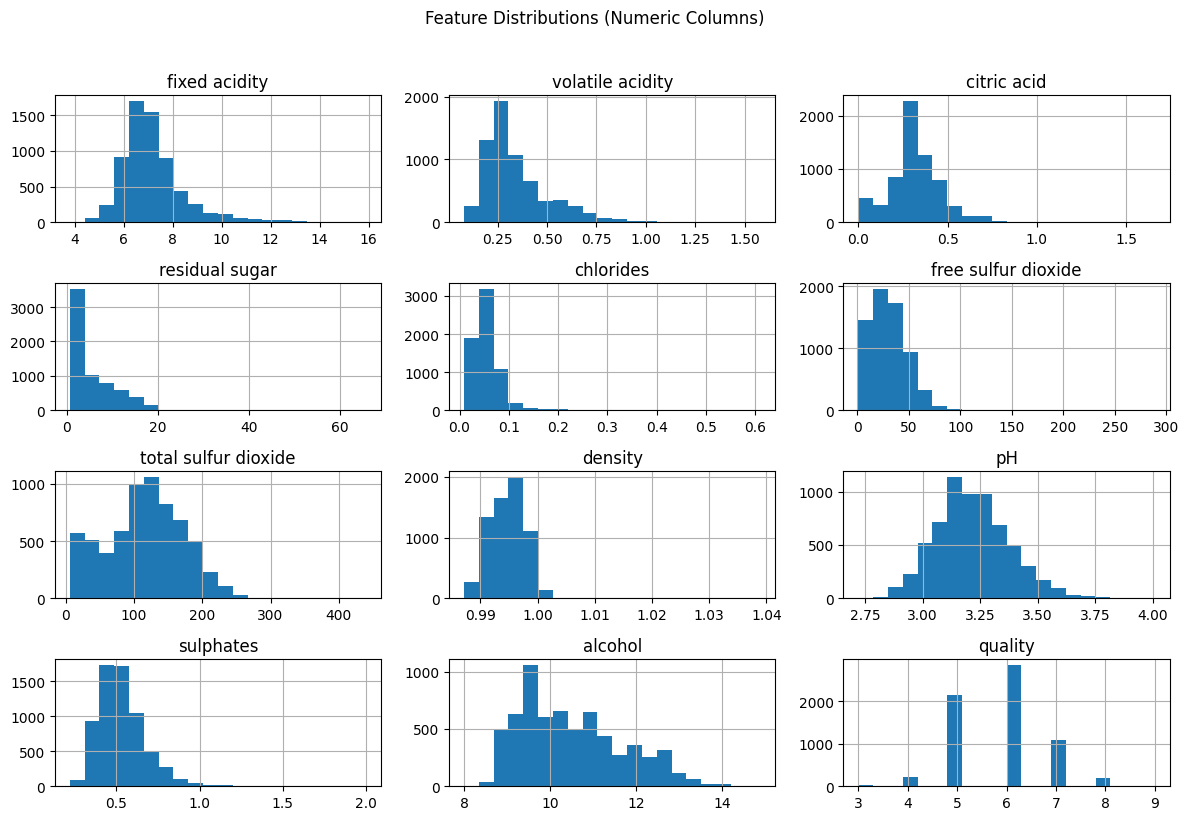

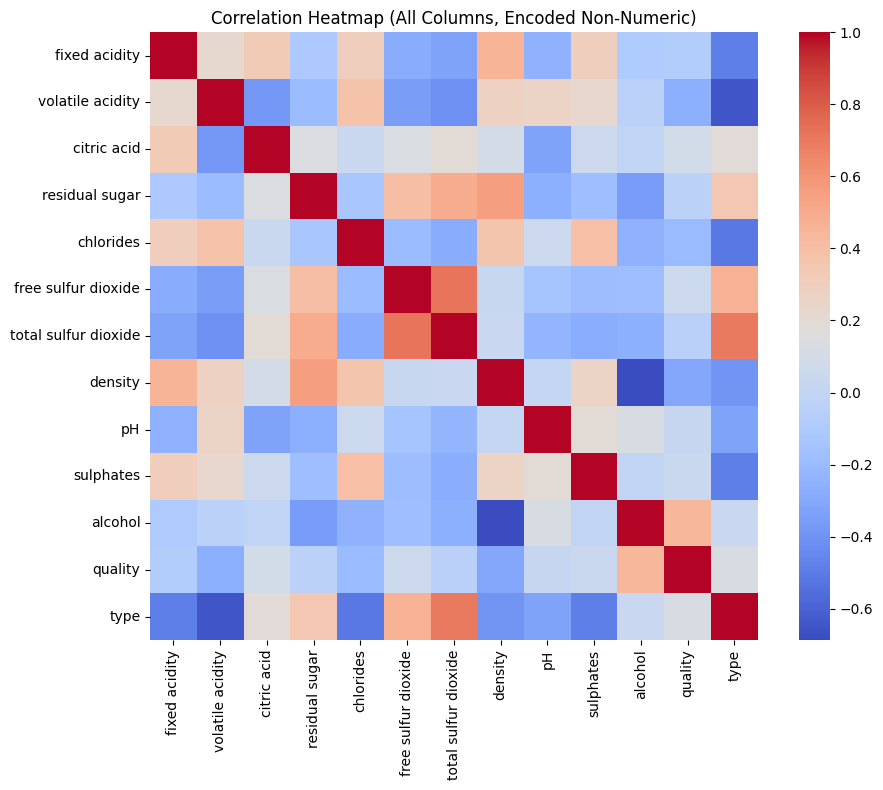

In [4]:


# Target (wine type) distribution ----
print("\nTarget column used for classification:", target_col)
print("\nValue counts for wine type (encoded):")
print(df[target_col].value_counts())

pt.figure(figsize=(5, 4))
sns.countplot(x=df[target_col])
pt.title("Wine Type Distribution (Encoded)")
pt.xlabel("Wine Type (0/1)")
pt.ylabel("Count")
pt.tight_layout()
pt.show()

# Numeric feature columns (excluding the target so plots are only for features)
numeric_feature_cols = df.drop(columns=[target_col]).select_dtypes(
    include=["int64", "float64", "int32", "float32"]
).columns.tolist()

print("\nNumeric feature columns:")
print(numeric_feature_cols)

pt.figure(figsize=(12, 8))
df[numeric_feature_cols].hist(figsize=(12, 8), bins=20)
pt.suptitle("Feature Distributions (Numeric Columns)", y=1.02)
pt.tight_layout()
pt.show()

# Full correlation heatmap
from sklearn.preprocessing import LabelEncoder
corr_df = df.copy()

# Encode any object (string) columns, e.g. wine type "red"/"white"
for col in corr_df.columns:
    if corr_df[col].dtype == "object":
        le = LabelEncoder()
        corr_df[col] = le.fit_transform(corr_df[col].astype(str))

pt.figure(figsize=(10, 8))
corr = corr_df.corr()  # now all columns are numeric
sns.heatmap(corr, annot=False, cmap="coolwarm", square=True)
pt.title("Correlation Heatmap (All Columns, Encoded Non-Numeric)")
pt.tight_layout()
pt.show()



### Observation:
Confirmed the imbalance with visualization.  
Visualized feature distributions.  
Checked Correlation between the attributes.  

## 4. 10-fold cross-validation (RF, KNN, Conv1D)

In [5]:
kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

results = {"RF": [], "KNN": [], "Conv1D": []}
n_features = X.shape[1]

for fold, (train_indices, test_indices) in enumerate(kfold.split(X, y_arr), start=1):
    x_train, x_test = X[train_indices], X[test_indices]
    y_train, y_test = y_arr[train_indices], y_arr[test_indices]

    # Baseline for Brier Skill Score
    p_base = y_train.mean()
    baseline_prob = ny.full_like(y_test, fill_value=p_base, dtype="float32")

    fold_metrics = {}

    # Random Forest and KNN Algorithms
    classic_models = {
        "RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
        "KNN": KNeighborsClassifier(n_neighbors=13),
    }

    for name, model in classic_models.items():
        model.fit(x_train, y_train)
        prob = model.predict_proba(x_test)[:, 1]
        pred = (prob >= 0.5).astype(int)

        cm = confusion_matrix(y_test, pred)
        m = calc_metrics_from_cm(cm)

        bs = brier_score_loss(y_test, prob)
        bs_ref = brier_score_loss(y_test, baseline_prob)
        bss = 1.0 - bs / bs_ref if bs_ref > 0 else 0.0

        m["AUC"] = roc_auc_score(y_test, prob)
        m["BS"] = bs
        m["BSS"] = bss

        results[name].append(m)
        fold_metrics[name] = m

    # Conv1D Algorithm
    x_train_seq = x_train.reshape(-1, n_features, 1)
    x_test_seq = x_test.reshape(-1, n_features, 1)

    conv_model = build_conv1d(n_features)
    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    )
    conv_model.fit(
        x_train_seq,
        y_train,
        epochs=40,
        batch_size=64,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
    )

    conv_prob = conv_model.predict(x_test_seq).ravel()
    conv_pred = (conv_prob >= 0.5).astype(int)

    cm_conv = confusion_matrix(y_test, conv_pred)
    m_conv = calc_metrics_from_cm(cm_conv)

    bs_conv = brier_score_loss(y_test, conv_prob)
    bs_ref_conv = brier_score_loss(y_test, baseline_prob)
    bss_conv = 1.0 - bs_conv / bs_ref_conv if bs_ref_conv > 0 else 0.0

    m_conv["AUC"] = roc_auc_score(y_test, conv_prob)
    m_conv["BS"] = bs_conv
    m_conv["BSS"] = bss_conv

    results["Conv1D"].append(m_conv)
    fold_metrics["Conv1D"] = m_conv

    # Per fold summary table with all required metrics
    cols_show = [
        "TP", "TN", "FP", "FN", "P", "N",
        "TPR", "TNR", "FPR", "FNR",
        "Precision", "F1", "Accuracy", "Error_rate",
        "BACC", "TSS", "HSS",
        "AUC", "BS", "BSS",
    ]
    fold_metrics_df = ps.DataFrame(fold_metrics).T[cols_show]

    print(f"\n-- Fold {fold} results --")
    print(fold_metrics_df.round(3))


C:\Users\alaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

-- Fold 1 results --
           TP     TN    FP   FN      P      N    TPR    TNR    FPR    FNR  \
RF      477.0  170.0   2.0  1.0  478.0  172.0  0.998  0.988  0.012  0.002   
KNN     472.0  169.0   3.0  6.0  478.0  172.0  0.987  0.983  0.017  0.013   
Conv1D  475.0  162.0  10.0  3.0  478.0  172.0  0.994  0.942  0.058  0.006   

        Precision     F1  Accuracy  Error_rate   BACC    TSS    HSS    AUC  \
RF          0.996  0.997     0.995       0.005  0.993  0.986  0.988  1.000   
KNN         0.994  0.991     0.986       0.014  0.985  0.970  0.965  0.999   
Conv1D      0.979  0.987     0.980       0.020  0.968  0.936  0.948  0.995   

           BS    BSS  
RF      0.005  0.974  
KNN     0.009  0.953  
Conv1D  0.019  0.905  


C:\Users\alaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

-- Fold 2 results --
           TP     TN    FP   FN      P      N    TPR    TNR    FPR    FNR  \
RF      481.0  165.0   4.0  0.0  481.0  169.0  1.000  0.976  0.024  0.000   
KNN     480.0  164.0   5.0  1.0  481.0  169.0  0.998  0.970  0.030  0.002   
Conv1D  479.0  146.0  23.0  2.0  481.0  169.0  0.996  0.864  0.136  0.004   

        Precision     F1  Accuracy  Error_rate   BACC    TSS    HSS    AUC  \
RF          0.992  0.996     0.994       0.006  0.988  0.976  0.984  0.999   
KNN         0.990  0.994     0.991       0.009  0.984  0.968  0.976  0.991   
Conv1D      0.954  0.975     0.962       0.038  0.930  0.860  0.896  0.990   

           BS    BSS  
RF      0.007  0.962  
KNN     0.009  0.955  
Conv1D  0.027  0.858  


C:\Users\alaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

-- Fold 3 results --
           TP     TN    FP   FN      P      N    TPR    TNR    FPR    FNR  \
RF      489.0  159.0   2.0  0.0  489.0  161.0  1.000  0.988  0.012  0.000   
KNN     485.0  159.0   2.0  4.0  489.0  161.0  0.992  0.988  0.012  0.008   
Conv1D  488.0  138.0  23.0  1.0  489.0  161.0  0.998  0.857  0.143  0.002   

        Precision     F1  Accuracy  Error_rate   BACC    TSS    HSS    AUC  \
RF          0.996  0.998     0.997       0.003  0.994  0.988  0.992  1.000   
KNN         0.996  0.994     0.991       0.009  0.990  0.979  0.975  0.996   
Conv1D      0.955  0.976     0.963       0.037  0.928  0.855  0.896  0.986   

           BS    BSS  
RF      0.004  0.976  
KNN     0.007  0.960  
Conv1D  0.031  0.835  


C:\Users\alaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

-- Fold 4 results --
           TP     TN    FP   FN      P      N    TPR    TNR    FPR    FNR  \
RF      471.0  170.0   6.0  3.0  474.0  176.0  0.994  0.966  0.034  0.006   
KNN     472.0  172.0   4.0  2.0  474.0  176.0  0.996  0.977  0.023  0.004   
Conv1D  470.0  163.0  13.0  4.0  474.0  176.0  0.992  0.926  0.074  0.008   

        Precision     F1  Accuracy  Error_rate   BACC    TSS    HSS    AUC  \
RF          0.987  0.991     0.986       0.014  0.980  0.960  0.965  0.999   
KNN         0.992  0.994     0.991       0.009  0.987  0.973  0.977  0.997   
Conv1D      0.973  0.982     0.974       0.026  0.959  0.918  0.933  0.997   

           BS    BSS  
RF      0.009  0.953  
KNN     0.007  0.963  
Conv1D  0.020  0.901  


C:\Users\alaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

-- Fold 5 results --
           TP     TN   FP   FN      P      N    TPR    TNR    FPR    FNR  \
RF      503.0  146.0  0.0  1.0  504.0  146.0  0.998  1.000  0.000  0.002   
KNN     502.0  145.0  1.0  2.0  504.0  146.0  0.996  0.993  0.007  0.004   
Conv1D  500.0  140.0  6.0  4.0  504.0  146.0  0.992  0.959  0.041  0.008   

        Precision     F1  Accuracy  Error_rate   BACC    TSS    HSS    AUC  \
RF          1.000  0.999     0.998       0.002  0.999  0.998  0.996  1.000   
KNN         0.998  0.997     0.995       0.005  0.995  0.989  0.987  1.000   
Conv1D      0.988  0.990     0.985       0.015  0.975  0.951  0.956  0.995   

           BS    BSS  
RF      0.004  0.979  
KNN     0.004  0.977  
Conv1D  0.012  0.931  


C:\Users\alaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

-- Fold 6 results --
           TP     TN    FP   FN      P      N    TPR    TNR    FPR    FNR  \
RF      495.0  154.0   1.0  0.0  495.0  155.0  1.000  0.994  0.006  0.000   
KNN     494.0  154.0   1.0  1.0  495.0  155.0  0.998  0.994  0.006  0.002   
Conv1D  494.0  134.0  21.0  1.0  495.0  155.0  0.998  0.865  0.135  0.002   

        Precision     F1  Accuracy  Error_rate   BACC    TSS    HSS    AUC  \
RF          0.998  0.999     0.998       0.002  0.997  0.994  0.996  1.000   
KNN         0.998  0.998     0.997       0.003  0.996  0.992  0.992  1.000   
Conv1D      0.959  0.978     0.966       0.034  0.931  0.862  0.902  0.992   

           BS    BSS  
RF      0.003  0.983  
KNN     0.003  0.984  
Conv1D  0.024  0.867  


C:\Users\alaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

-- Fold 7 results --
           TP     TN    FP   FN      P      N    TPR    TNR    FPR    FNR  \
RF      488.0  159.0   2.0  1.0  489.0  161.0  0.998  0.988  0.012  0.002   
KNN     488.0  159.0   2.0  1.0  489.0  161.0  0.998  0.988  0.012  0.002   
Conv1D  487.0  148.0  13.0  2.0  489.0  161.0  0.996  0.919  0.081  0.004   

        Precision     F1  Accuracy  Error_rate   BACC    TSS    HSS    AUC  \
RF          0.996  0.997     0.995       0.005  0.993  0.986  0.988  1.000   
KNN         0.996  0.997     0.995       0.005  0.993  0.986  0.988  0.997   
Conv1D      0.974  0.985     0.977       0.023  0.958  0.915  0.937  0.995   

           BS    BSS  
RF      0.004  0.978  
KNN     0.005  0.975  
Conv1D  0.018  0.905  


C:\Users\alaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

-- Fold 8 results --
           TP     TN    FP   FN      P      N    TPR    TNR    FPR    FNR  \
RF      472.0  173.0   4.0  0.0  472.0  177.0  1.000  0.977  0.023  0.000   
KNN     470.0  174.0   3.0  2.0  472.0  177.0  0.996  0.983  0.017  0.004   
Conv1D  466.0  157.0  20.0  6.0  472.0  177.0  0.987  0.887  0.113  0.013   

        Precision     F1  Accuracy  Error_rate   BACC    TSS    HSS    AUC  \
RF          0.992  0.996     0.994       0.006  0.989  0.977  0.984  0.996   
KNN         0.994  0.995     0.992       0.008  0.989  0.979  0.981  0.994   
Conv1D      0.959  0.973     0.960       0.040  0.937  0.874  0.896  0.990   

           BS    BSS  
RF      0.007  0.964  
KNN     0.007  0.964  
Conv1D  0.029  0.852  


C:\Users\alaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

-- Fold 9 results --
           TP     TN    FP   FN      P      N    TPR    TNR    FPR    FNR  \
RF      510.0  135.0   4.0  0.0  510.0  139.0  1.000  0.971  0.029  0.000   
KNN     505.0  138.0   1.0  5.0  510.0  139.0  0.990  0.993  0.007  0.010   
Conv1D  507.0  129.0  10.0  3.0  510.0  139.0  0.994  0.928  0.072  0.006   

        Precision     F1  Accuracy  Error_rate   BACC    TSS    HSS    AUC  \
RF          0.992  0.996     0.994       0.006  0.986  0.971  0.981  1.000   
KNN         0.998  0.994     0.991       0.009  0.992  0.983  0.973  0.996   
Conv1D      0.981  0.987     0.980       0.020  0.961  0.922  0.939  0.993   

           BS    BSS  
RF      0.006  0.963  
KNN     0.007  0.958  
Conv1D  0.019  0.891  


C:\Users\alaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

-- Fold 10 results --
           TP     TN    FP   FN      P      N    TPR    TNR    FPR    FNR  \
RF      505.0  143.0   0.0  1.0  506.0  143.0  0.998  1.000  0.000  0.002   
KNN     506.0  142.0   1.0  0.0  506.0  143.0  1.000  0.993  0.007  0.000   
Conv1D  501.0  132.0  11.0  5.0  506.0  143.0  0.990  0.923  0.077  0.010   

        Precision     F1  Accuracy  Error_rate   BACC    TSS    HSS    AUC  \
RF          1.000  0.999     0.998       0.002  0.999  0.998  0.996  1.000   
KNN         0.998  0.999     0.998       0.002  0.997  0.993  0.996  1.000   
Conv1D      0.979  0.984     0.975       0.025  0.957  0.913  0.927  0.995   

           BS    BSS  
RF      0.003  0.982  
KNN     0.002  0.986  
Conv1D  0.019  0.889  


In [6]:
#Show all 10 folds for each algorithm (RF,KNN,Conv1D)

# metrics
cols_show = [
    "TP", "TN", "FP", "FN", "P", "N",
    "TPR", "TNR", "FPR", "FNR",
    "Precision", "F1", "Accuracy", "Error_rate",
    "BACC", "TSS", "HSS",
    "AUC", "BS", "BSS",
]

# fold names
num_folds = len(next(iter(results.values())))  # length of any list in results
fold_names = [f"fold{i}" for i in range(1, num_folds + 1)]

for model_name in ["KNN", "RF", "Conv1D"]:
    df_model = ps.DataFrame(results[model_name])[cols_show]
    df_model.index = fold_names

    print(f"\nAll {model_name} folds metrics:\n")
    print(df_model.T.round(3))
    print("\n")



All KNN folds metrics:

              fold1    fold2    fold3    fold4    fold5    fold6    fold7  \
TP          472.000  480.000  485.000  472.000  502.000  494.000  488.000   
TN          169.000  164.000  159.000  172.000  145.000  154.000  159.000   
FP            3.000    5.000    2.000    4.000    1.000    1.000    2.000   
FN            6.000    1.000    4.000    2.000    2.000    1.000    1.000   
P           478.000  481.000  489.000  474.000  504.000  495.000  489.000   
N           172.000  169.000  161.000  176.000  146.000  155.000  161.000   
TPR           0.987    0.998    0.992    0.996    0.996    0.998    0.998   
TNR           0.983    0.970    0.988    0.977    0.993    0.994    0.988   
FPR           0.017    0.030    0.012    0.023    0.007    0.006    0.012   
FNR           0.013    0.002    0.008    0.004    0.004    0.002    0.002   
Precision     0.994    0.990    0.996    0.992    0.998    0.998    0.996   
F1            0.991    0.994    0.994    0.994    0

## 5. Average metrics over all folds

In [7]:
metrics_order = [
    "TP", "TN", "FP", "FN", "P", "N",
    "TPR", "TNR", "FPR", "FNR",
    "Precision", "F1", "Accuracy", "Error_rate",
    "BACC", "TSS", "HSS",
    "AUC", "BS", "BSS",
]

avg_tables = {}
for name, res_list in results.items():
    df_metrics = ps.DataFrame(res_list)
    avg_tables[name] = df_metrics[metrics_order].mean()

avg_df = ps.DataFrame(avg_tables, index=metrics_order)
print("Mean metric avg values for 10 folds:\n")
print(avg_df.round(3))


Mean metric avg values for 10 folds:

                 RF      KNN   Conv1D
TP          489.100  487.400  486.700
TN          157.400  157.600  144.900
FP            2.500    2.300   15.000
FN            0.700    2.400    3.100
P           489.800  489.800  489.800
N           159.900  159.900  159.900
TPR           0.999    0.995    0.994
TNR           0.985    0.986    0.907
FPR           0.015    0.014    0.093
FNR           0.001    0.005    0.006
Precision     0.995    0.995    0.970
F1            0.997    0.995    0.982
Accuracy      0.995    0.993    0.972
Error_rate    0.005    0.007    0.028
BACC          0.992    0.991    0.950
TSS           0.983    0.981    0.901
HSS           0.987    0.981    0.923
AUC           0.999    0.997    0.993
BS            0.005    0.006    0.022
BSS           0.971    0.967    0.883


These avg metrics can also hepls compare the three models easily

## 6. ROC curves and AUC for RF, KNN, and Conv1D

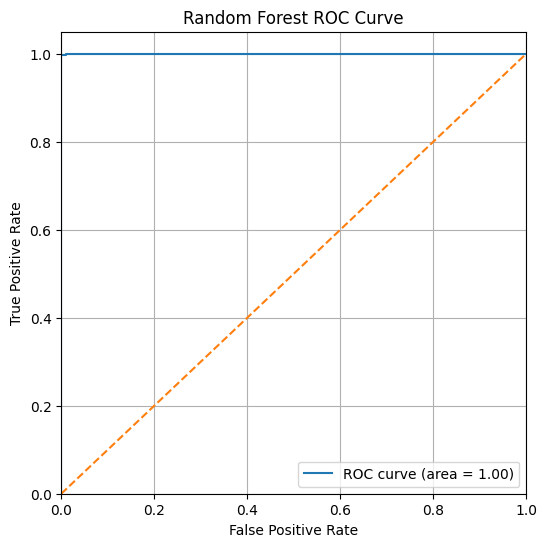

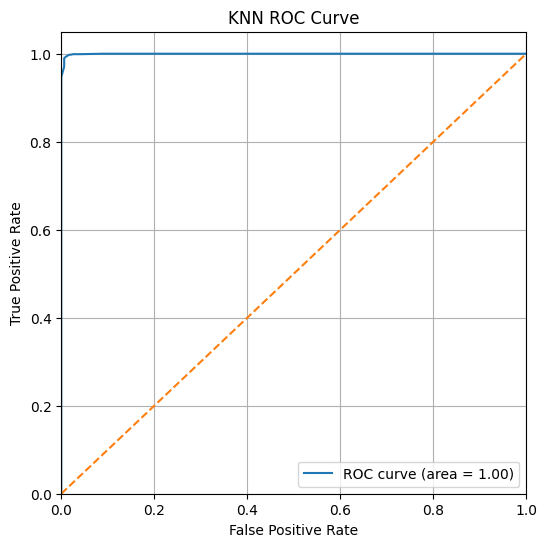

C:\Users\alaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


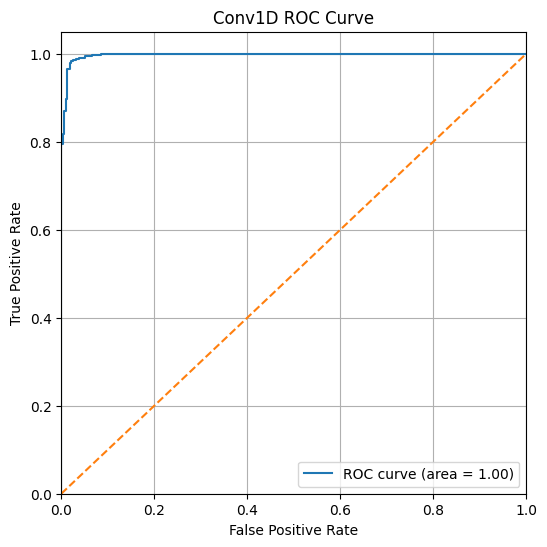

In [8]:
# Separate 20% hold-out test set for ROC comparison
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(
    X, y_arr, test_size=0.2, random_state=RANDOM_STATE, stratify=y_arr
)

# Random Forest ROC
rf_model = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf_model.fit(x_train_all, y_train_all)
rf_prob = rf_model.predict_proba(x_test_all)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test_all, rf_prob)
auc_rf = auc(fpr_rf, tpr_rf)

pt.figure(figsize=(6, 6))
pt.plot(fpr_rf, tpr_rf, label=f"ROC curve (area = {auc_rf:.2f})")
pt.plot([0, 1], [0, 1], linestyle="--")
pt.xlim([0.0, 1.0])
pt.ylim([0.0, 1.05])
pt.xlabel("False Positive Rate")
pt.ylabel("True Positive Rate")
pt.title("Random Forest ROC Curve")
pt.legend(loc="lower right")
pt.grid(True)
pt.show()

# KNN ROC
knn_model = KNeighborsClassifier(n_neighbors=13)
knn_model.fit(x_train_all, y_train_all)
knn_prob = knn_model.predict_proba(x_test_all)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test_all, knn_prob)
auc_knn = auc(fpr_knn, tpr_knn)

pt.figure(figsize=(6, 6))
pt.plot(fpr_knn, tpr_knn, label=f"ROC curve (area = {auc_knn:.2f})")
pt.plot([0, 1], [0, 1], linestyle="--")
pt.xlim([0.0, 1.0])
pt.ylim([0.0, 1.05])
pt.xlabel("False Positive Rate")
pt.ylabel("True Positive Rate")
pt.title("KNN ROC Curve")
pt.legend(loc="lower right")
pt.grid(True)
pt.show()

# Conv1D ROC
x_train_seq_all = x_train_all.reshape(-1, X.shape[1], 1)
x_test_seq_all = x_test_all.reshape(-1, X.shape[1], 1)

conv_model_roc = build_conv1d(X.shape[1])
early_stop_roc = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

conv_model_roc.fit(
    x_train_seq_all,
    y_train_all,
    epochs=40,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop_roc],
    verbose=0,
)

conv_prob = conv_model_roc.predict(x_test_seq_all).ravel()
fpr_conv, tpr_conv, _ = roc_curve(y_test_all, conv_prob)
auc_conv = auc(fpr_conv, tpr_conv)

pt.figure(figsize=(6, 6))
pt.plot(fpr_conv, tpr_conv, label=f"ROC curve (area = {auc_conv:.2f})")
pt.plot([0, 1], [0, 1], linestyle="--")
pt.xlim([0.0, 1.0])
pt.ylim([0.0, 1.05])
pt.xlabel("False Positive Rate")
pt.ylabel("True Positive Rate")
pt.title("Conv1D ROC Curve")
pt.legend(loc="lower right")
pt.grid(True)
pt.show()
